## Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результата. Что помогло повысить точность?

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D, 
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

(256, 512, 3)
2975


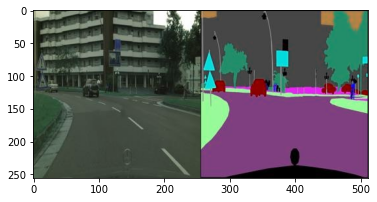

In [4]:
path = 'cityscapes_data/train/'
img1 = cv2.imread(path, 0)

flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [5]:
# чтение картинок и создание тренировочного датасета
szy, szx, _ = np.shape(img0)
N_ex = 500 # берём часть датасета
N_bias = 0
x_train = np.zeros((N_ex, szy, int(szx/2), 3))
y_train = np.zeros((N_ex, szy, int(szx/2), 3))
k = 0

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.imread(path+f)[:,:256]/256
    y_train[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

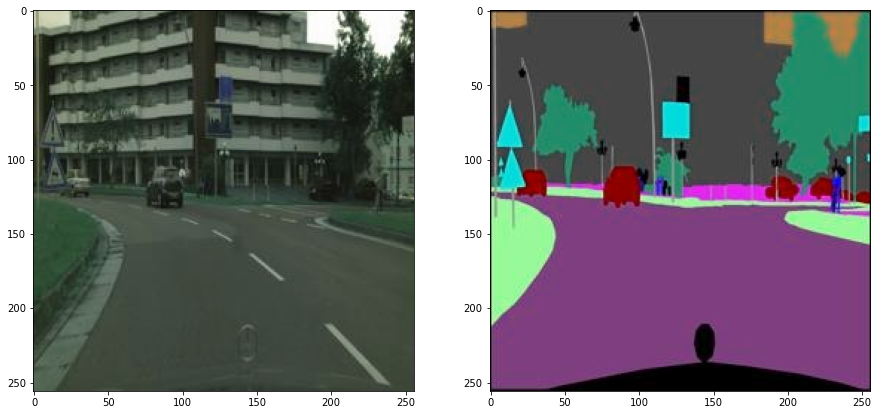

In [6]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0]);

In [7]:
# таким же образом подготавливаем тестовый дата сет
path = 'cityscapes_data/val/'
img1 = cv2.imread(path, 0)


flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 50

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_val[k] = cv2.imread(path+f)[:,:256]/256
    y_val[k] = cv2.imread(path+f)[:,256:]/256
    k = k+1

In [8]:
def Unet(num_classes=14, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # в Unet основной посыл в том, тобы прокидывать признаки в конец сетки,
    # когда уже идёт предсказание маски. Поэтому мы запоминаем этот слой и прокидываем его в конец
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)


    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # начинаем растягивать картинку
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # конкатенируем то что получили после 3-го увеличения и блок 3
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор (14 классов, поэтому softmax)
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

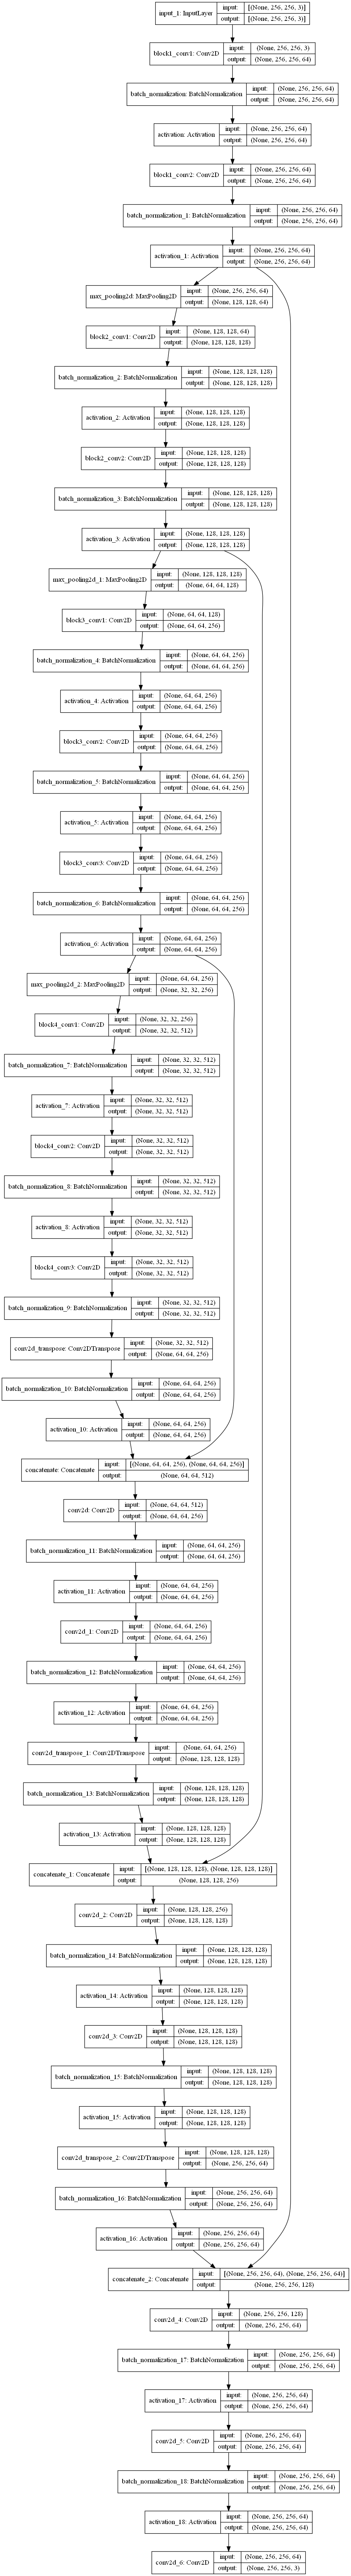

In [9]:
model_1 = Unet(3, (256, 256, 3))
plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [11]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [12]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
history_1 = model_1.fit(x_train, y_train,
                      epochs=1,
                      batch_size=10,
                      validation_data=(x_val, y_val),
                      )

50/50 [==============================] - 946s 19s/step - loss: 1.1327 - dice_coef: 0.3629 - val_loss: 1.5245 - val_dice_coef: 0.3187


In [15]:
pred_1 = model_1.predict(x_val)
print(pred_1.shape)

(50, 256, 256, 3)


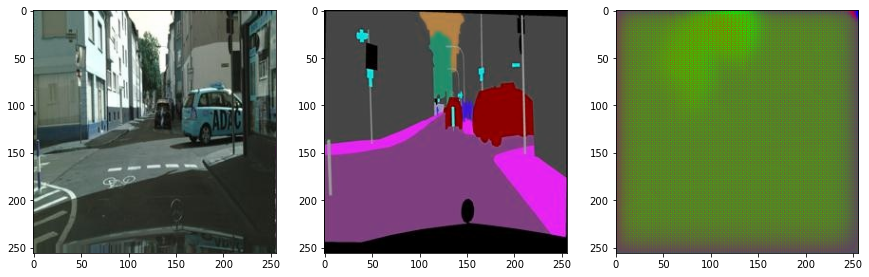

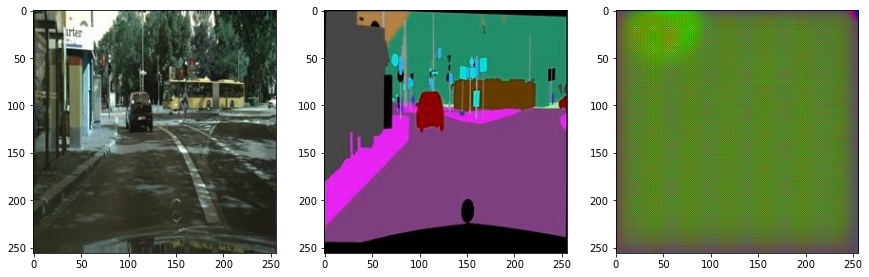

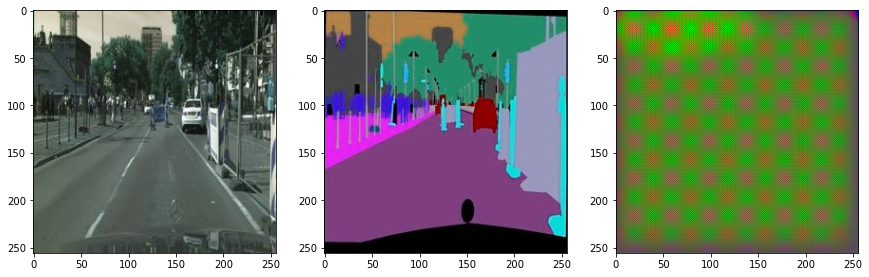

In [16]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred_1[k])

In [17]:
history_1 = model_1.fit(x_train, y_train,
                      epochs=3,
                      batch_size=10,
                      validation_data=(x_val, y_val),
                      )

Epoch 1/3
50/50 [==============================] - 960s 19s/step - loss: 1.1299 - dice_coef: 0.3595 - val_loss: 1.3014 - val_dice_coef: 0.3329
Epoch 2/3
50/50 [==============================] - 953s 19s/step - loss: 1.1307 - dice_coef: 0.3606 - val_loss: 1.2892 - val_dice_coef: 0.3583
Epoch 3/3
50/50 [==============================] - 959s 19s/step - loss: 1.1307 - dice_coef: 0.3619 - val_loss: 1.2566 - val_dice_coef: 0.3445


In [18]:
pred_1 = model_1.predict(x_val)

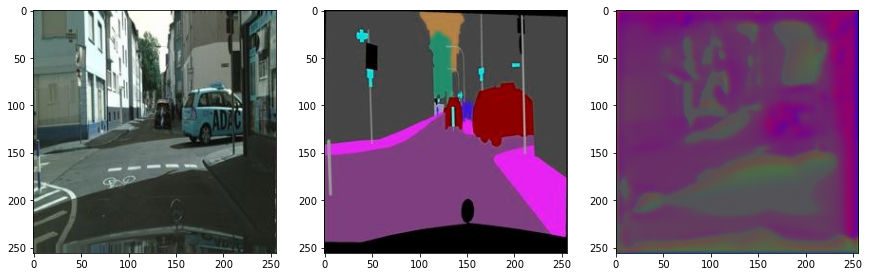

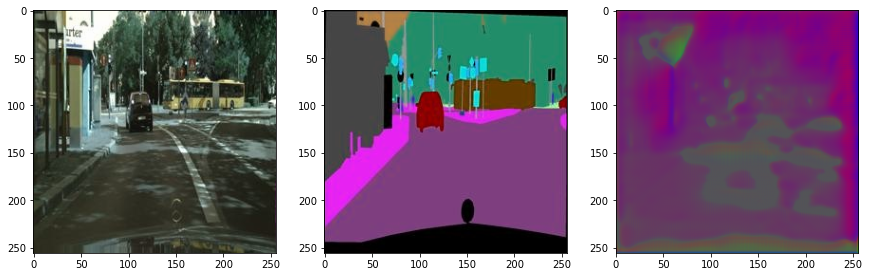

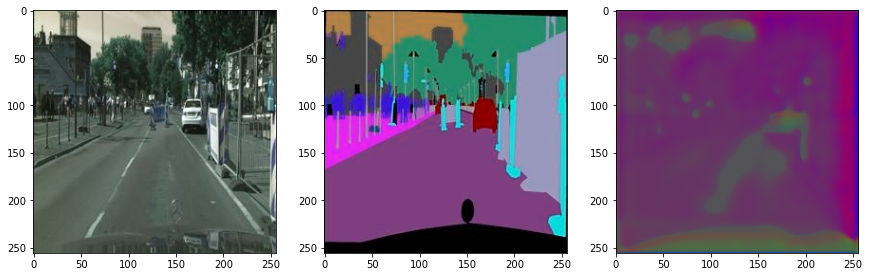

In [19]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred_1[k])

С увеличением числа эпох, точность явно улучшается. Попробуем 25 эпох.

In [20]:
history_1 = model_1.fit(x_train, y_train,
                      epochs=25,
                      batch_size=10,
                      validation_data=(x_val, y_val),
                      )

Epoch 1/25
50/50 [==============================] - 961s 19s/step - loss: 1.1342 - dice_coef: 0.3622 - val_loss: 1.3882 - val_dice_coef: 0.3515
Epoch 2/25
50/50 [==============================] - 964s 19s/step - loss: 1.1363 - dice_coef: 0.3629 - val_loss: 1.8520 - val_dice_coef: 0.3755
Epoch 3/25
50/50 [==============================] - 957s 19s/step - loss: 1.1338 - dice_coef: 0.3627 - val_loss: 1.2925 - val_dice_coef: 0.3455
Epoch 4/25
50/50 [==============================] - 927s 19s/step - loss: 1.1428 - dice_coef: 0.3642 - val_loss: 1.3205 - val_dice_coef: 0.3582
Epoch 5/25
50/50 [==============================] - 920s 18s/step - loss: 1.1452 - dice_coef: 0.3646 - val_loss: 1.1763 - val_dice_coef: 0.3600
Epoch 6/25
50/50 [==============================] - 919s 18s/step - loss: 1.1452 - dice_coef: 0.3650 - val_loss: 1.1163 - val_dice_coef: 0.3578
Epoch 7/25
50/50 [==============================] - 917s 18s/step - loss: 1.1526 - dice_coef: 0.3654 - val_loss: 1.1817 - val_dice_coef:

In [21]:
pred_1 = model_1.predict(x_val)

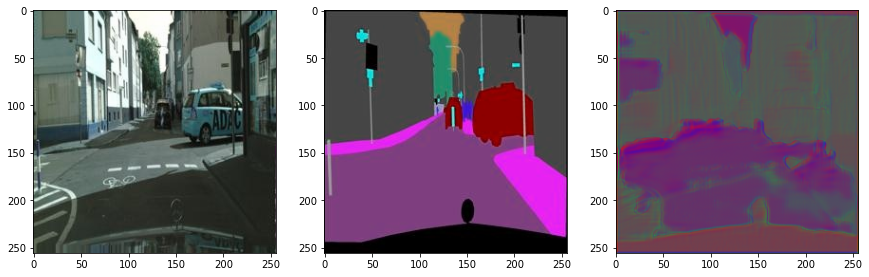

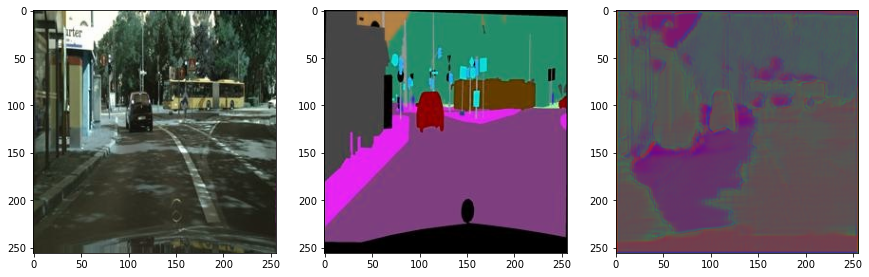

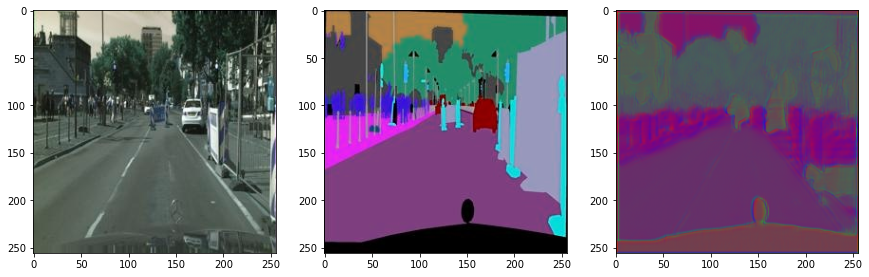

In [22]:
ni = 3
for k in range(ni):
    plt.figure(figsize=(20,60))

    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])

    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])

    plt.subplot(ni,4,3+k*4)
    plt.imshow(pred_1[k])

Посмотрим как количество эпох влияет на точность. Визуально влияние очень сильное.

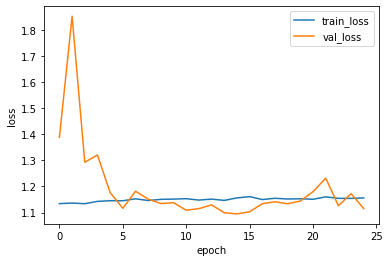

In [24]:
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

После 5 эпохи происходит своего рода насыщение и потери на тестовой выборке существенно не меняются.

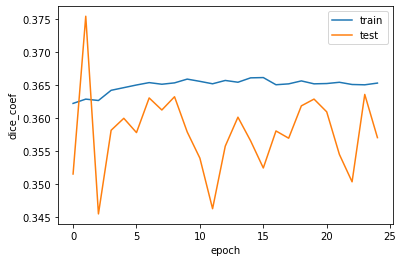

In [25]:
plt.plot(history_1.history['dice_coef'], label='train')
plt.plot(history_1.history['val_dice_coef'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Изменение dice_coef с ростом числа эпох не имеет выраженной тенденции как на тестовой так и на тренировочной выборках.

### Вывод:
Основными факторами влияющими на точность сети являются:
- число эпох;
- количество ядер в слоях Conv2D (чем больше ядер, тем выше точность);
- количество классов объектов;
- batch_size (хотя и не так сильно как число эпох, но тем не менее заметно).


Число эпох - основной фактор определяющий точность данной сети.